In [1]:
import requests
import json
import pandas as pd
import numpy as np

## 結果データを取得する

In [10]:
def getResultData(id):
    try:
        response = requests.get(f'https://oyster-app-8jboe.ondigitalocean.app/therb/{id}')
        data = json.loads(response.text)
        
        #jsonデータをpandasのdataframeに変換する
        return data['data']
    except:
        throw('no id matches data in database')

getResultDataに渡すidはtherb-frontendのUIのここから取得できます
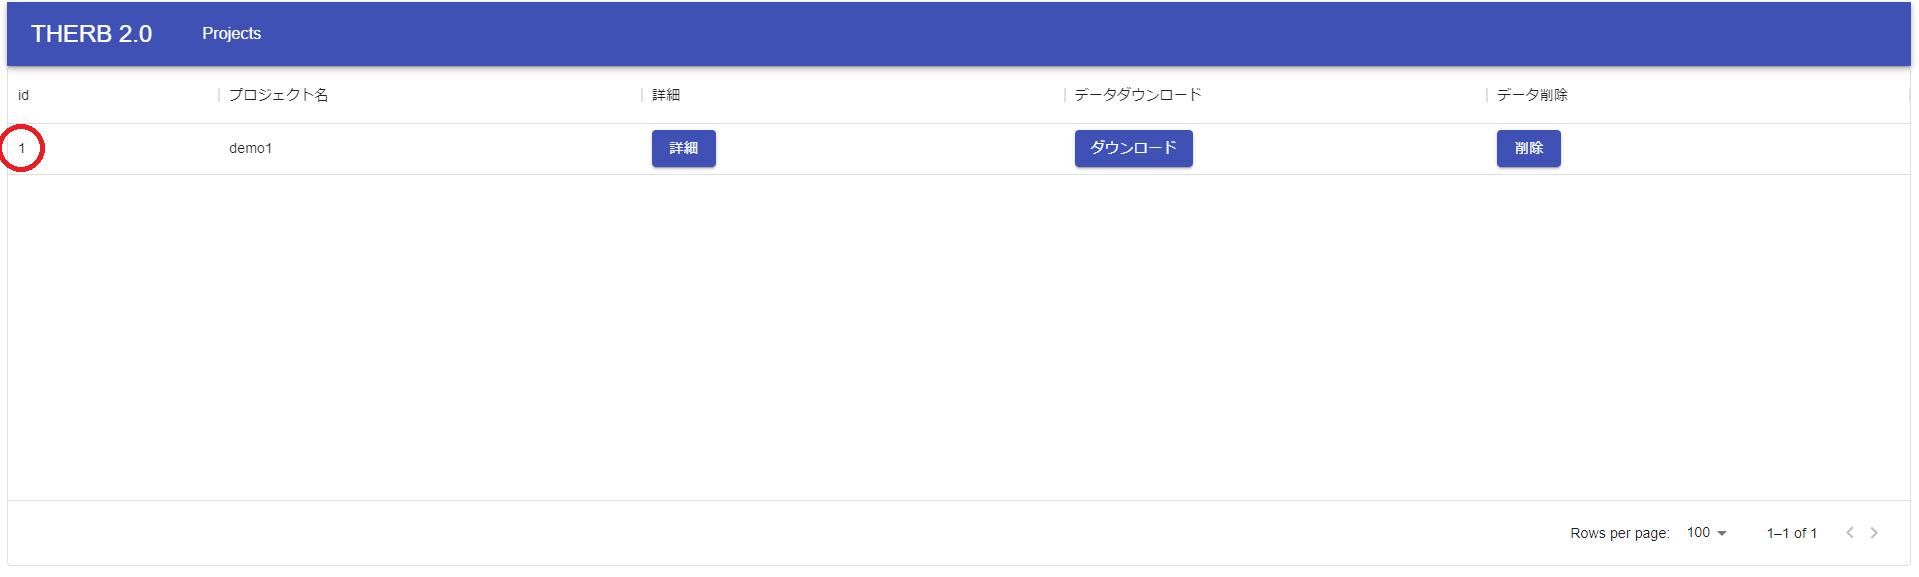

In [11]:
resultData = getResultData(1)

In [12]:
resultData

[{'roomId': 1,
  'results': {'time': ['01/05/24:00',
    '01/06/01:00',
    '01/06/02:00',
    '01/06/03:00',
    '01/06/04:00',
    '01/06/05:00',
    '01/06/06:00',
    '01/06/07:00',
    '01/06/08:00',
    '01/06/09:00',
    '01/06/10:00',
    '01/06/11:00',
    '01/06/12:00',
    '01/06/13:00',
    '01/06/14:00',
    '01/06/15:00',
    '01/06/16:00',
    '01/06/17:00',
    '01/06/18:00',
    '01/06/19:00',
    '01/06/20:00',
    '01/06/21:00',
    '01/06/22:00',
    '01/06/23:00',
    '01/06/24:00',
    '01/07/01:00',
    '01/07/02:00',
    '01/07/03:00',
    '01/07/04:00',
    '01/07/05:00',
    '01/07/06:00',
    '01/07/07:00',
    '01/07/08:00',
    '01/07/09:00',
    '01/07/10:00',
    '01/07/11:00',
    '01/07/12:00',
    '01/07/13:00',
    '01/07/14:00',
    '01/07/15:00',
    '01/07/16:00',
    '01/07/17:00',
    '01/07/18:00',
    '01/07/19:00',
    '01/07/20:00',
    '01/07/21:00',
    '01/07/22:00',
    '01/07/23:00',
    '01/07/24:00',
    '01/08/01:00',
    '01/08/02:00

部屋ごとにデータを整理できるようにする必要

In [13]:
def convertToDataframe(resultDict):
    columns = []
    rows = []
    for k,v in resultDict.items():
        columns.append(k)
        rows.append(v)
    
    #transposedRows = np.array(rows,dtype=np.float32).T
    transposedRows = np.array(rows).T
    df = pd.DataFrame(data = transposedRows, columns = columns) 
    df=df.set_index('time')
    df=df.astype('float32')
    #return transposedRows
    return df

In [14]:
df_room1 = convertToDataframe(resultData[0]['results'])
df_room2 = convertToDataframe(resultData[1]['results'])

In [16]:
df_room2

,temp,relHumidity,absHumidity
time,,,
01/05/24:00,4.67,4.67,0.0
01/06/01:00,4.67,4.67,0.0
01/06/02:00,4.67,4.67,0.0
01/06/03:00,4.67,4.67,0.0
01/06/04:00,4.67,4.67,0.0
...,...,...,...
12/31/20:00,4.77,4.77,0.0
12/31/21:00,4.75,4.76,0.0
12/31/22:00,4.74,4.75,0.0


## とりあえず折れ線グラフで可視化してみる

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

### データをすぐに確認するのはpandasのほうが早い

<AxesSubplot:xlabel='hour'>

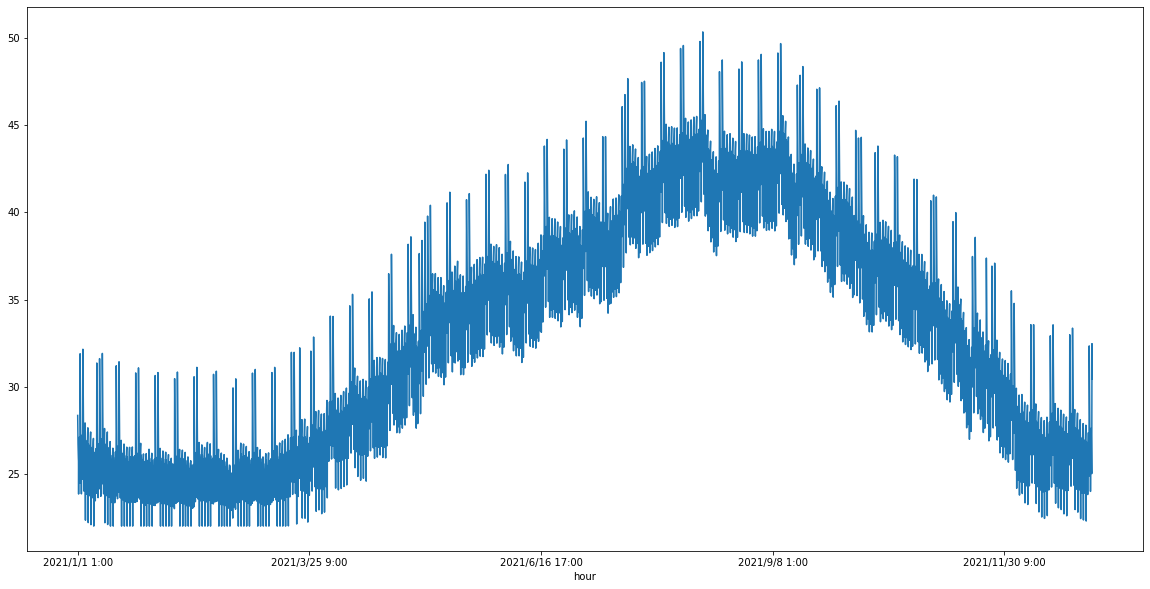

In [38]:
df_room1['roomT'].plot.line(figsize=(20,10))

どの温度の時間帯が多いか？

<AxesSubplot:xlabel='hour'>

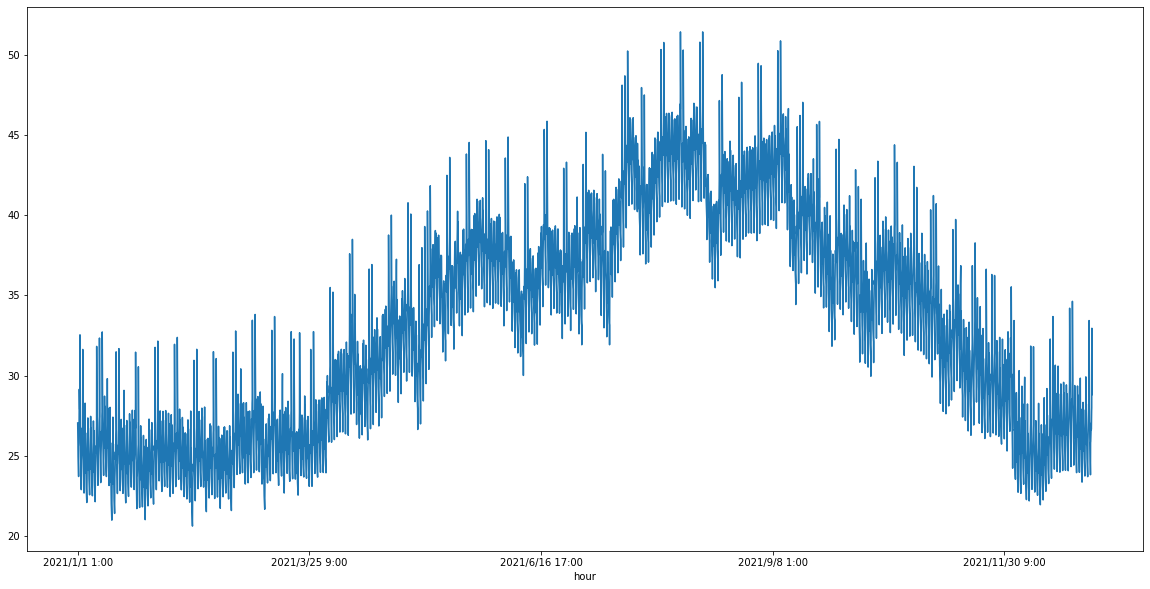

In [40]:
df_room2['roomT'].plot.line(figsize=(20,10))

<AxesSubplot:>

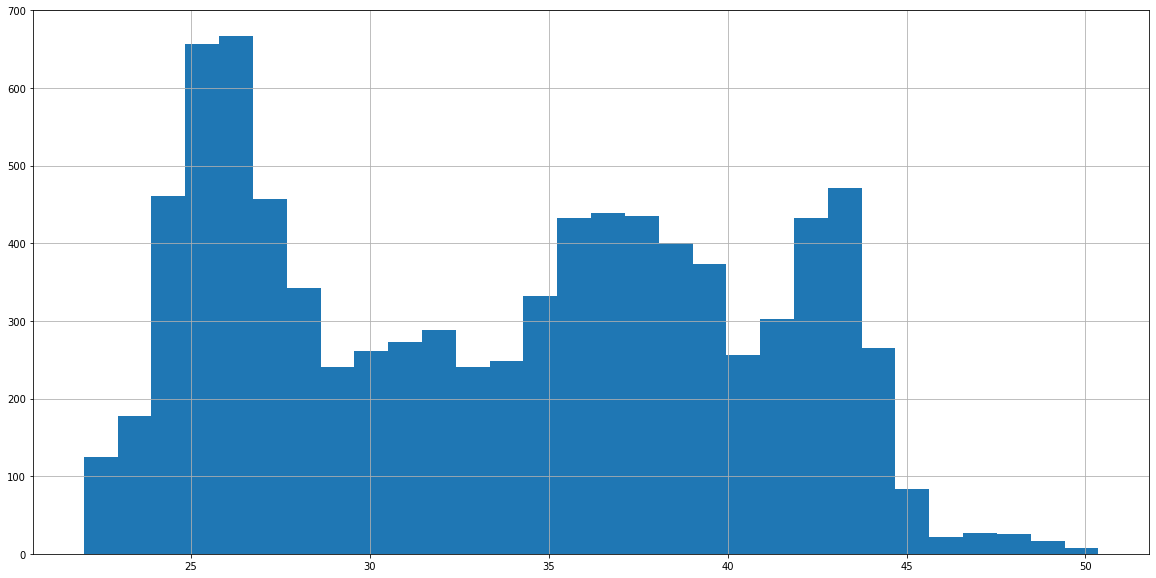

In [42]:
df_room1['roomT'].hist(figsize=(20,10),bins=30)

### 快適時間帯の割合は？

In [43]:
def calcPercentage(data,min,max):
    maxSatisfied = data[lambda x: x<max]
    satisfied = maxSatisfied[lambda x: x>min]
    percentage = len(satisfied)/len(data)*100
    return round(percentage,1)

In [44]:
calcPercentage(df_room1['roomT'],20,28)

30.5

In [45]:
calcPercentage(df_room2['roomT'],20,28)

31.3

In [46]:
calcPercentage(df_room3['roomT'],20,28)

66.0

### visualizeの見栄えをよくする

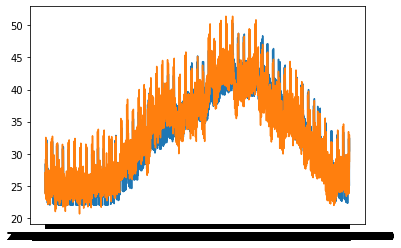

In [33]:
plt.plot(df_room1.index,df_room1['roomT'],label = "room1")
plt.plot(df_room2.index,df_room2['roomT'],label = "room2")

#### Seabornは時間がかかりすぎ

<AxesSubplot:xlabel='hour', ylabel='roomT'>

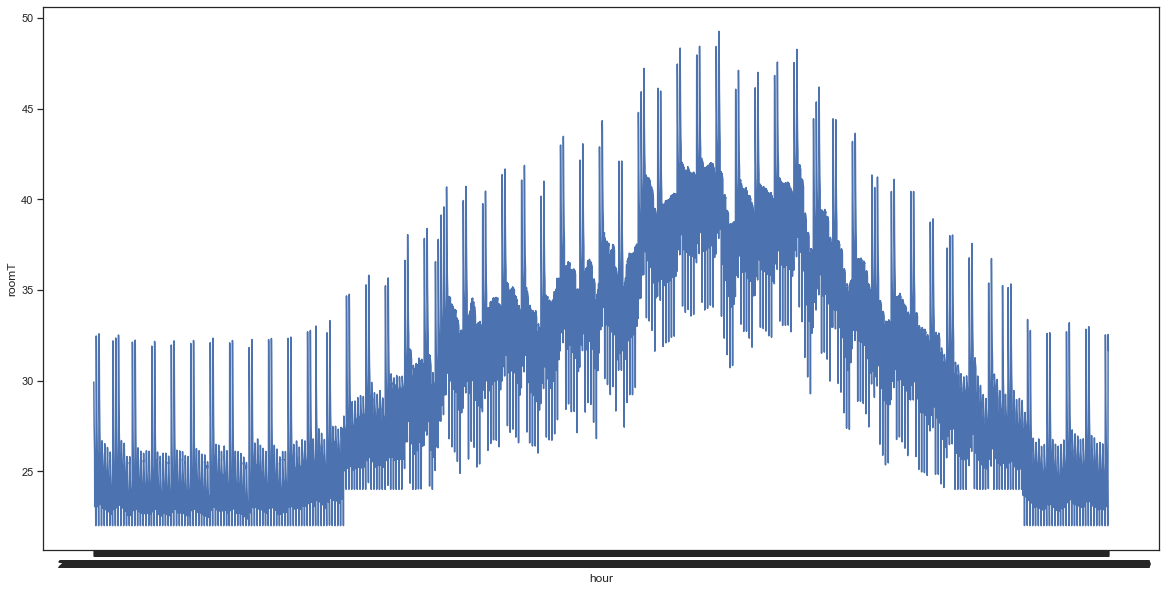

In [104]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x="hour", y="roomT")